El objetivo de este notebook es plotear y analizar tiempos / spikes de experimentos. Por un lado cargamos un archivo donde se indica el tiempo de activación del láser, y por otro tenemos los spikes. Tenemos que plotear primero, de manera coordinada, la información de ambos archivos.

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import datetime as dt
import os
import seaborn as sns

In [113]:
hoy = dt.date.today()

In [114]:
df_times = pd.read_csv('tiempos.csv', sep=', ', header=None, index_col=0)
#df_times

/var/folders/b0/y3jz8svn7n3c3f_4751rp9480000gn/T/ipykernel_1646/936114925.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_times = pd.read_csv('tiempos.csv', sep=', ', header=None, index_col=0)


In [325]:
exp_date = '2024_02_20'

name_sample = 'D19_POSTsiembra_D6_(IV)(000)'
name_file_spikes = f'{name_sample}_spike_list.csv'
name_file_laser = '202402020_MEAs_D6_(IV).csv'

timestamp = [int(i) for i in df_times[1].loc[name_sample].split(':')]

time_absolute_start = dt.datetime.combine(hoy, dt.time(timestamp[0], timestamp[1], timestamp[2], timestamp[3] * 1000))  # A1_(IV)_(000)

os.makedirs(f'../../results/{exp_date}', exist_ok=True)


time_absolute_start
type(time_absolute_start)

datetime.datetime

In [326]:
df_spikes = pd.read_csv(f"../../spike_lists/{exp_date}/{name_file_spikes}", sep=';', encoding='unicode_escape')
df_spikes

,ï»¿Investigator,Unnamed: 1,Time (s),Electrode,Amplitude (mV)
0,Recording Name,D19_POSTsiembra_D6_(IV),0.20416,D6_22,0.068
1,Description,NaN,0.37472,D6_22,0.066
2,Maestro Edge (Maestro-091) Settings,NaN,0.51680,D6_22,0.064
3,Original File Time,02/20/2024 14:33:35,0.66712,D6_22,0.067
4,Sampling Frequency,12.5 kHz,0.81736,D6_22,0.058
...,...,...,...,...,...
38704,NaN,NaN,199.10912,D6_14,0.019
38705,NaN,NaN,199.11288,D6_43,0.070
38706,NaN,NaN,199.70080,D6_22,0.072
38707,NaN,NaN,199.85280,D6_22,0.070


In [327]:

df_spikes['electrode_str'] = [i.split('_')[1] for i in df_spikes['Electrode']]
df_spikes['electrode_coord'] = [(int(electrode[0])-1, 3-(int(electrode[1])-1)) for electrode in df_spikes['electrode_str']]
df_spikes

,ï»¿Investigator,Unnamed: 1,Time (s),Electrode,Amplitude (mV),electrode_str,electrode_coord
0,Recording Name,D19_POSTsiembra_D6_(IV),0.20416,D6_22,0.068,22,"(1, 2)"
1,Description,NaN,0.37472,D6_22,0.066,22,"(1, 2)"
2,Maestro Edge (Maestro-091) Settings,NaN,0.51680,D6_22,0.064,22,"(1, 2)"
3,Original File Time,02/20/2024 14:33:35,0.66712,D6_22,0.067,22,"(1, 2)"
4,Sampling Frequency,12.5 kHz,0.81736,D6_22,0.058,22,"(1, 2)"
...,...,...,...,...,...,...,...
38704,NaN,NaN,199.10912,D6_14,0.019,14,"(0, 0)"
38705,NaN,NaN,199.11288,D6_43,0.070,43,"(3, 1)"
38706,NaN,NaN,199.70080,D6_22,0.072,22,"(1, 2)"
38707,NaN,NaN,199.85280,D6_22,0.070,22,"(1, 2)"


In [328]:
df_laser = pd.read_csv(f"../../tiempos_structura/{exp_date}/{name_file_laser}", sep=',')
df_laser['Turn ON Laser Time'].iloc[1]

'14:33:41.288877'

In [329]:
df_laser['Turn ON Laser Time']

0     14:33:38.148215
1     14:33:41.288877
2     14:33:44.419812
3     14:33:47.553034
4     14:33:50.692677
5     14:33:53.831812
6     14:33:56.978826
7     14:34:00.118646
8     14:34:03.252703
9     14:34:06.398685
10    14:34:09.533587
11    14:34:12.657737
12    14:34:15.804203
13    14:34:18.937894
14    14:34:22.061853
15    14:34:25.199960
16    14:34:28.345345
17    14:34:31.473870
18    14:34:34.613272
19    14:34:37.752695
20    14:34:40.890343
21    14:34:44.037649
22    14:34:47.186019
23    14:34:50.319470
24    14:34:53.454817
25    14:34:56.601988
26    14:34:59.740065
27    14:35:02.864533
28    14:35:05.998131
29    14:35:09.137338
30    14:35:12.271103
31    14:35:15.410774
32    14:35:18.545284
33    14:35:21.680591
34    14:35:24.813894
35    14:35:27.945539
36    14:35:31.090974
37    14:35:34.226643
38    14:35:37.353466
39    14:35:40.490703
40    14:35:43.629487
41    14:35:46.779368
42    14:35:49.923398
43    14:35:53.055615
44    14:35:56.194998
45    14:3

In [330]:
df_laser['Turn ON Laser Time'] = pd.to_datetime(df_laser['Turn ON Laser Time'] , infer_datetime_format=True)
df_laser['Turn OFF Laser Time'] = pd.to_datetime(df_laser['Turn OFF Laser Time'] , infer_datetime_format=True)
df_laser

,Unnamed: 0,Repetition,ON duration (ms),Laser Power (mW),Turn ON Laser Time,Turn OFF Laser Time,Turn ON Laser Time (ms)
0,0,1,100,0,2024-02-29 14:33:38.148215,2024-02-29 14:33:38.254680,0 days 00:00:00.106465
1,1,2,100,0,2024-02-29 14:33:41.288877,2024-02-29 14:33:41.398818,0 days 00:00:00.109941
2,2,3,100,0,2024-02-29 14:33:44.419812,2024-02-29 14:33:44.529753,0 days 00:00:00.109941
3,3,4,100,0,2024-02-29 14:33:47.553034,2024-02-29 14:33:47.662975,0 days 00:00:00.109941
4,4,5,100,0,2024-02-29 14:33:50.692677,2024-02-29 14:33:50.802621,0 days 00:00:00.109944
5,5,6,100,0,2024-02-29 14:33:53.831812,2024-02-29 14:33:53.941787,0 days 00:00:00.109975
6,6,7,100,0,2024-02-29 14:33:56.978826,2024-02-29 14:33:57.088783,0 days 00:00:00.109957
7,7,8,100,0,2024-02-29 14:34:00.118646,2024-02-29 14:34:00.228589,0 days 00:00:00.109943
8,8,9,100,0,2024-02-29 14:34:03.252703,2024-02-29 14:34:03.362644,0 days 00:00:00.109941
9,9,10,100,0,2024-02-29 14:34:06.398685,2024-02-29 14:34:06.508626,0 days 00:00:00.109941


In [331]:

#df_laser['Turn ON Laser Time'] = pd.to_datetime(df_laser['Turn ON Laser Time'])
#df_laser['Turn ON Laser Time'] = pd.datetime.timestamp(df_laser['Turn ON Laser Time'])
#df_laser['Turn ON Laser Time'] = pd.datetime.strptime(df_laser['Turn ON Laser Time'])
df_laser['start_times'] = [((df_laser['Turn ON Laser Time'].iloc[i]) - time_absolute_start).total_seconds() for i in range(len(df_laser))]
df_laser['end_times'] = [((df_laser['Turn OFF Laser Time'].iloc[i]) - time_absolute_start).total_seconds() for i in range(len(df_laser))]
df_laser['duration'] = df_laser['ON duration (ms)'] / 1000
df_laser


,Unnamed: 0,Repetition,ON duration (ms),Laser Power (mW),Turn ON Laser Time,Turn OFF Laser Time,Turn ON Laser Time (ms),start_times,end_times,duration
0,0,1,100,0,2024-02-29 14:33:38.148215,2024-02-29 14:33:38.254680,0 days 00:00:00.106465,2.900215,3.006680,0.1
1,1,2,100,0,2024-02-29 14:33:41.288877,2024-02-29 14:33:41.398818,0 days 00:00:00.109941,6.040877,6.150818,0.1
2,2,3,100,0,2024-02-29 14:33:44.419812,2024-02-29 14:33:44.529753,0 days 00:00:00.109941,9.171812,9.281753,0.1
3,3,4,100,0,2024-02-29 14:33:47.553034,2024-02-29 14:33:47.662975,0 days 00:00:00.109941,12.305034,12.414975,0.1
4,4,5,100,0,2024-02-29 14:33:50.692677,2024-02-29 14:33:50.802621,0 days 00:00:00.109944,15.444677,15.554621,0.1
5,5,6,100,0,2024-02-29 14:33:53.831812,2024-02-29 14:33:53.941787,0 days 00:00:00.109975,18.583812,18.693787,0.1
6,6,7,100,0,2024-02-29 14:33:56.978826,2024-02-29 14:33:57.088783,0 days 00:00:00.109957,21.730826,21.840783,0.1
7,7,8,100,0,2024-02-29 14:34:00.118646,2024-02-29 14:34:00.228589,0 days 00:00:00.109943,24.870646,24.980589,0.1
8,8,9,100,0,2024-02-29 14:34:03.252703,2024-02-29 14:34:03.362644,0 days 00:00:00.109941,28.004703,28.114644,0.1
9,9,10,100,0,2024-02-29 14:34:06.398685,2024-02-29 14:34:06.508626,0 days 00:00:00.109941,31.150685,31.260626,0.1


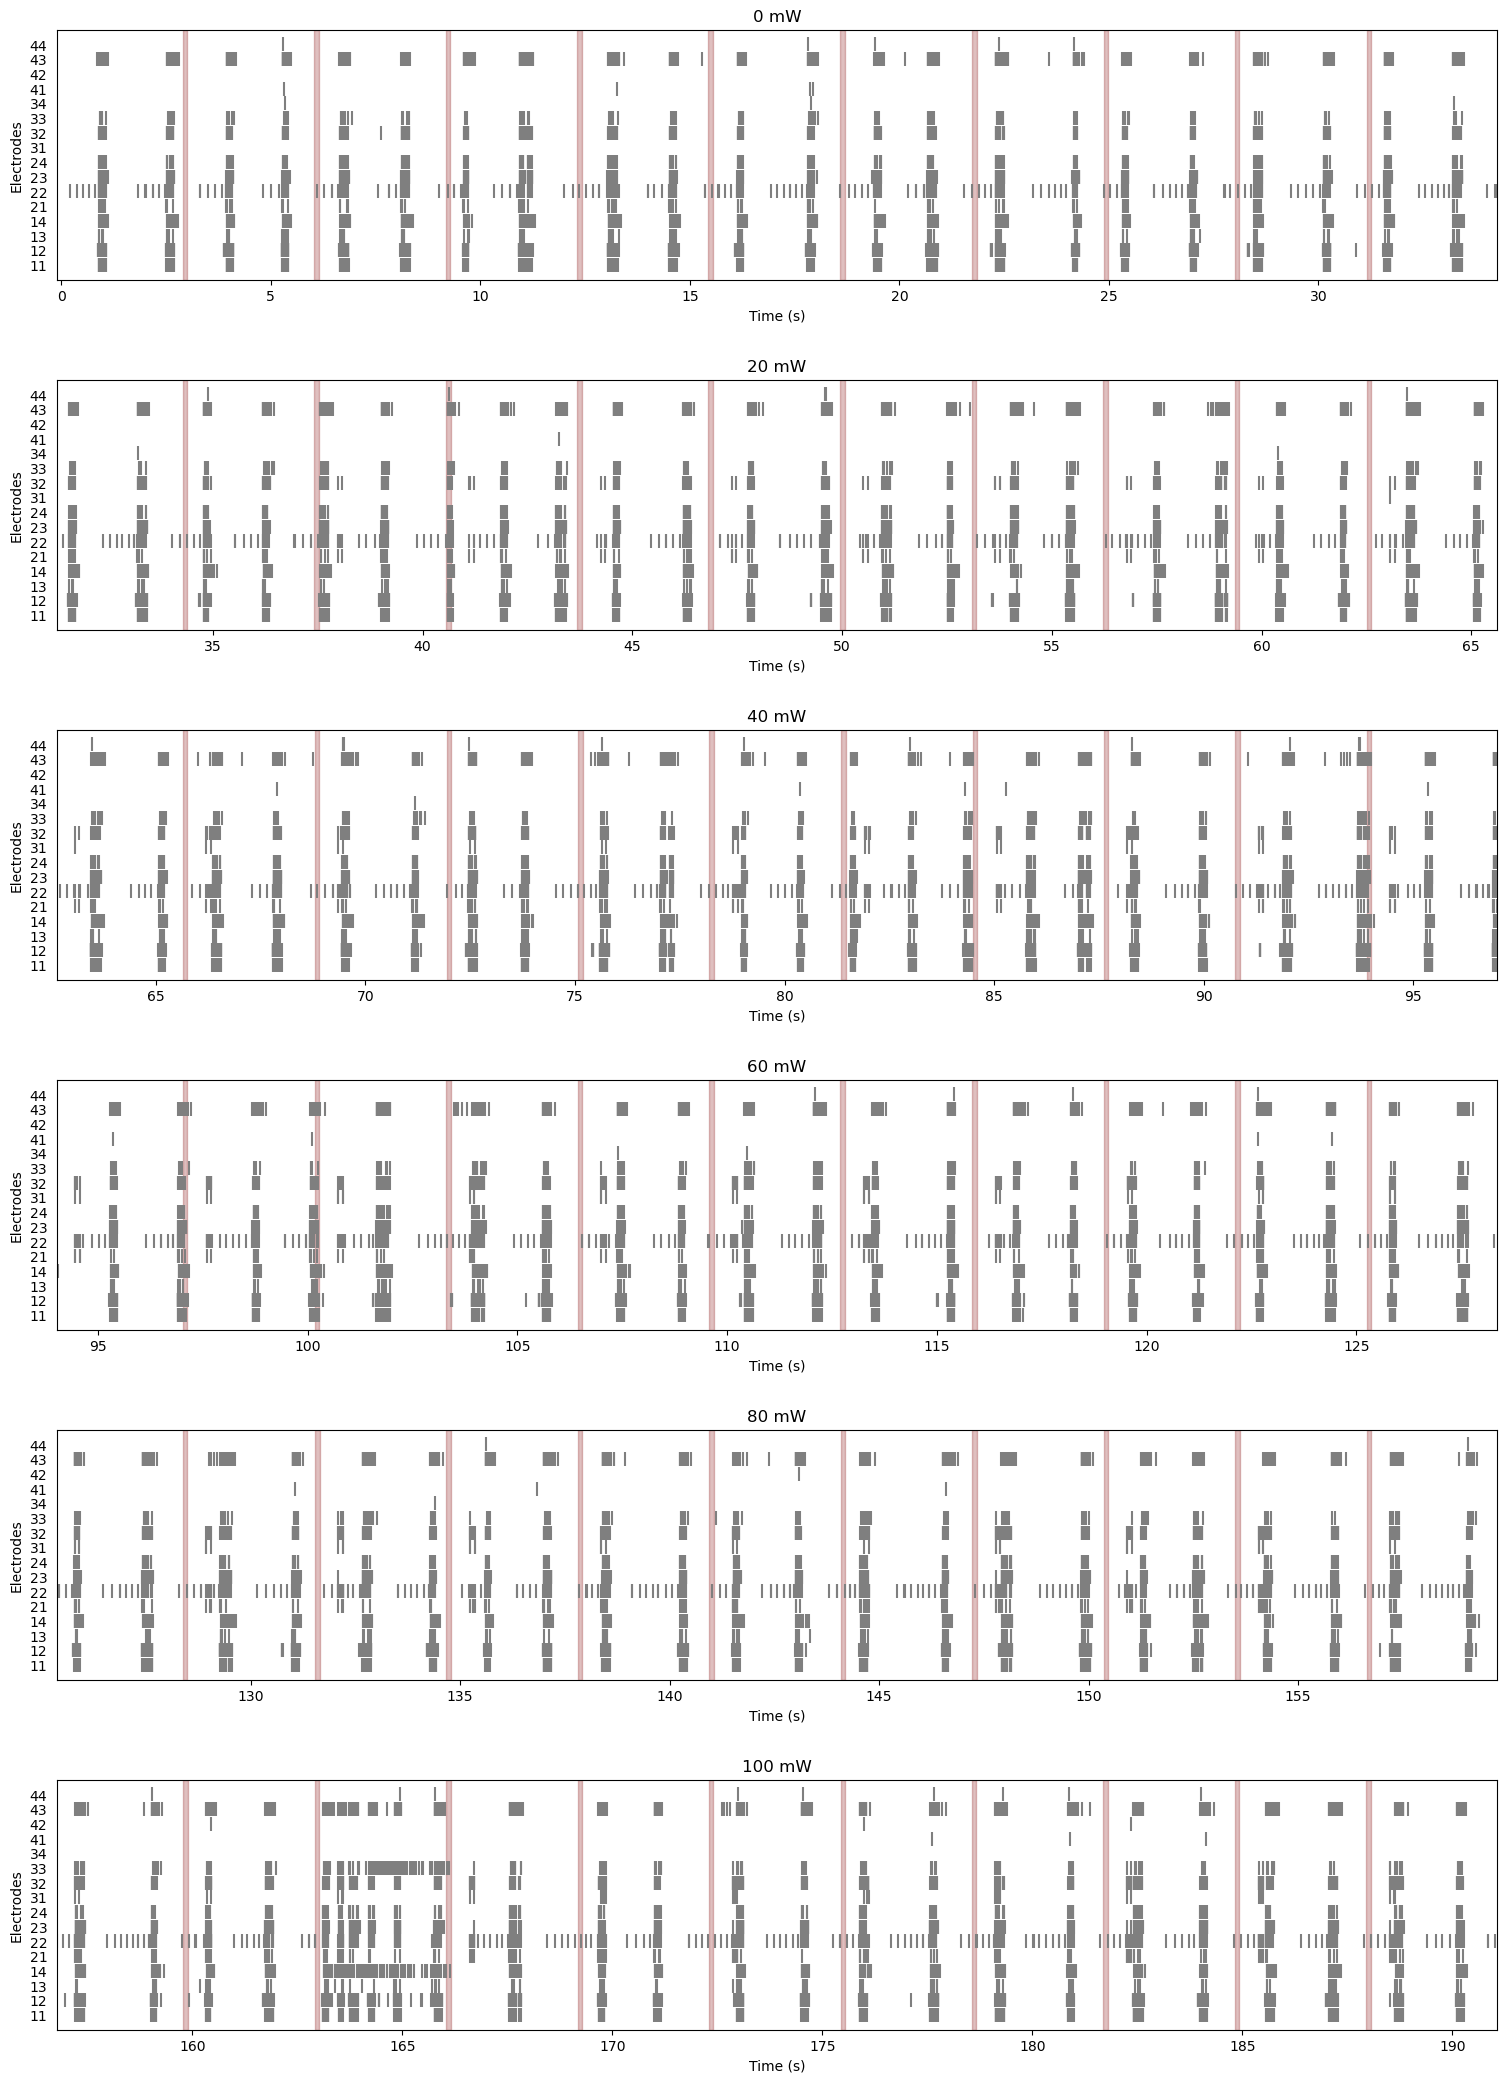

In [332]:
voltages = sorted(set(df_laser['Laser Power (mW)'].values))
electrodes = sorted(set(df_spikes['electrode_str'].values))

window = 3

fig, axs = plt.subplots(len(voltages), 1, figsize=(18, 25))

for idx, voltage in enumerate(voltages):
    df_laser_sub = df_laser[df_laser['Laser Power (mW)'] == voltage]
    t_0, t_f = min(df_laser_sub['start_times']), max(df_laser_sub['end_times'])


    for rep, start, end in zip(df_laser_sub['Repetition'].values, df_laser_sub['start_times'].values, df_laser_sub['end_times'].values):
        axs[idx].add_patch(mpl.patches.Rectangle((start, -1), end - start, len(electrodes)+1, alpha=0.25, color='#800000') )

    for electrode_idx, electrode in enumerate(electrodes):
        df_spikes_sub = df_spikes[(df_spikes['Time (s)'] > t_0 - window) & (df_spikes['Time (s)'] < t_f+window) & (df_spikes['electrode_str'] == electrode)]
        axs[idx].scatter(x=df_spikes_sub['Time (s)'].values, y=[electrode_idx] * len(df_spikes_sub), marker='|', s=100, c='#7f7f7f')
    


    axs[idx].set_yticks(np.array(range(len(electrodes))))
    axs[idx].set_yticklabels(electrodes)
    axs[idx].set_ylim([-1, len(electrodes)])
    axs[idx].set_xlim([t_0 - window, t_f+window])
    axs[idx].tick_params(left = False) 
    axs[idx].set_xlabel('Time (s)')
    axs[idx].set_ylabel('Electrodes')

    axs[0].title.set_text('0 mW')
    axs[1].title.set_text('20 mW')
    axs[2].title.set_text('40 mW')
    axs[3].title.set_text('60 mW')
    axs[4].title.set_text('80 mW')
    axs[5].title.set_text('100 mW')
    

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



plt.savefig(f'../../results/{exp_date}/{name_sample}.png', dpi=300)

# Calculating the mean representation time between pulses

In [ ]:
tw = 0.1

time_ranges = np.arange(np.min(df_laser['start_times']) , np.max(df_laser['end_times']) , tw)
time_ranges_mean = (time_ranges[1:] + time_ranges[:-1]) * 0.5 

counts = np.array([len(df_spikes[(df_spikes['Time (s)'] >= start) & (df_spikes['Time (s)'] < end)]) for start, end in zip(time_ranges[:-1], time_ranges[1: ])])
len(counts)

In [ ]:
tmps = np.argwhere(counts > 80).flatten() * tw
diff = tmps[1: ] - tmps[: -1]
sns.swarmplot(diff[diff > 2 * tw])